In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True' + ',dnn.enabled=False'
# /nfs/team283/vk7/software/miniconda3farm5/envs/cellpymc/bin/pip install git+https://github.com/vitkl/cell2location.git
#sys.path.insert(1, '/nfs/team283/ed6/cellLocModel/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location/')
#import cellLocModel as clm
import pycell2location.models as c2l
import pycell2location.plt as c2lpl
import pycell2location.cluster_averages 
from matplotlib import rcParams
import seaborn as sns
# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Can not use cuDNN on context None: Disabled by dnn.enabled flag
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:62:00.0)


In [2]:
rSlides = np.array(('00MU', '00MV')) # slide we want to look at
AOI_type = ['Geometric'] #np.array(('HOPXpos', 'EOMESpos', 'Residual', 'Ring', 'Geometric'))
Radial_positions = np.array((2))

# Let's load the data and metadata from our Nanostring experiment:

counts = pd.read_table('/nfs/team283/aa16/KR_NAS/Sanger_288ROIs_TargetCountMatrix.txt')
genes = counts['TargetName']
counts = counts.drop('TargetName',1)
counts = counts.rename(index=genes)
counts = counts.astype('int')
counts = counts[np.array([sum(counts.iloc[i,:]) for i in range(len(counts.iloc[:,0]))]) > 3 * 288]
metadata = pd.read_csv('/nfs/team283/aa16/KR_NAS/NanoString sequencing all annotations 2020.02.10.csv')
metadata = metadata.iloc[0:286,]
metadata = metadata.rename(index=metadata['Sanger_sampleID'])
metadata = metadata.reindex(np.array(counts.columns))
properties = pd.read_table('/nfs/team283/aa16/KR_NAS/Sanger_288ROIs_SegmentProperties.txt')
properties = properties.rename(index=properties['DSP_Sample_ID'])
properties = properties.reindex(np.array(metadata['Sample_ID']))
columnNames = ('x', 'y', 'total_counts', 'Q3_counts')
sample_info = pd.DataFrame(index=metadata['Sample_ID'], columns=columnNames)
sample_info['x'] = np.array(metadata['VCDepth'])
sample_info['y'] = np.array(metadata['Radial_position'])
sample_info['total_counts'] = [sum(counts.iloc[:,i]) for i in range(len(counts.iloc[1,:]))] 
sample_info['Q3_counts'] = [sum(np.sort(counts.iloc[:,i])[int(np.round(0.5*len(counts.iloc[:,i]))):int(np.round(0.75*len(counts.iloc[:,i])))]) for i in range(len(counts.iloc[1,:]))] 

# Let's load the Polioudakis 2019 data as a reference, as well as the cell type specific marker genes:

polioudakis = pd.read_csv('/nfs/team283/brainData/human_fetal/Polioudakis2019/subclusterMeans.csv')
markers = pd.read_csv('/nfs/team283/brainData/human_fetal/Polioudakis2019/subclusterMarkers.csv')
genes = polioudakis.iloc[:,0]
polioudakis = polioudakis.drop('Unnamed: 0',1)
polioudakis = polioudakis.rename(index=genes)

# Choose the top N markers only:

N = 10
columnNames = np.unique(markers['cluster'])
topN_markers = pd.DataFrame(index=range(N), columns=columnNames)
for i in range(len(columnNames)):
    topN_temp = np.array(markers[markers['cluster'] == columnNames[i]].iloc[0:N,].iloc[:,0])
    topN_markers[columnNames[i]] = [topN_temp[i].split('.')[0] for i in range(len(topN_temp))]
topN_array = np.array(topN_markers).flatten()  

subset_rois = [metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in Radial_positions and metadata['AOI_type'][i] in AOI_type for i in range(len(metadata['slide']))]
relevantIDs = metadata['Sample_ID'][subset_rois]
relevantSangerIDs = metadata['Sanger_sampleID'][subset_rois]
counts_subset = counts.loc[:,relevantSangerIDs]
subset_genes = [counts_subset.index[i] in topN_array for i in range(len(counts_subset.index))]
counts_subset = counts_subset.iloc[subset_genes,:]
polioudakis_subset = polioudakis.reindex(np.array(counts_subset.index))

polioudakis_subset = polioudakis.reindex(np.array(counts_subset.index))

In [3]:
mod1 = c2l.LocationModelV6(
        np.array(polioudakis_subset), np.array(counts_subset).T,
        data_type='float32', n_iter=50000,
        learning_rate=0.001,
        total_grad_norm_constraint=200,
        verbose=False)

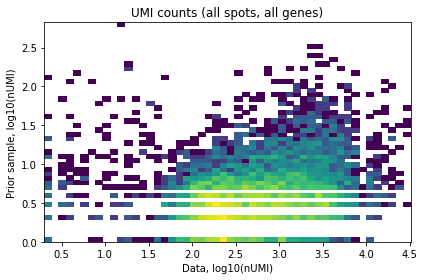

In [4]:
mod1.sample_prior()
mod1.plot_prior_vs_data()

In [5]:
mod1.fit_advi(n=3, method='advi')

Average Loss = 72,315: 100%|██████████| 50000/50000 [36:27<00:00, 22.86it/s]    
Finished [100%]: Average Loss = 72,315
Average Loss = 72,434: 100%|██████████| 50000/50000 [18:11<00:00, 45.81it/s]    
Finished [100%]: Average Loss = 72,433
Average Loss = 72,463: 100%|██████████| 50000/50000 [01:11<00:00, 701.20it/s]    
Finished [100%]: Average Loss = 72,465


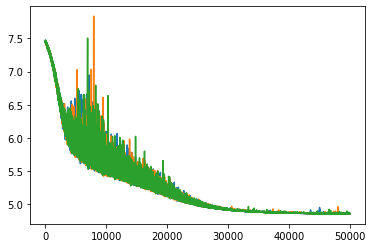

In [6]:
mod1.plot_history()

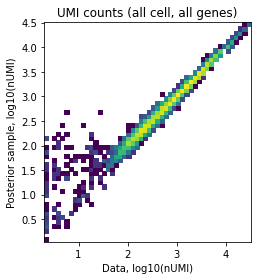

In [7]:
mod1.sample_posterior(node='all', n_samples=1000, save_samples=False);

mod1.sample2df()

mod1.compute_expected()
mod1.plot_posterior_mu_vs_data()

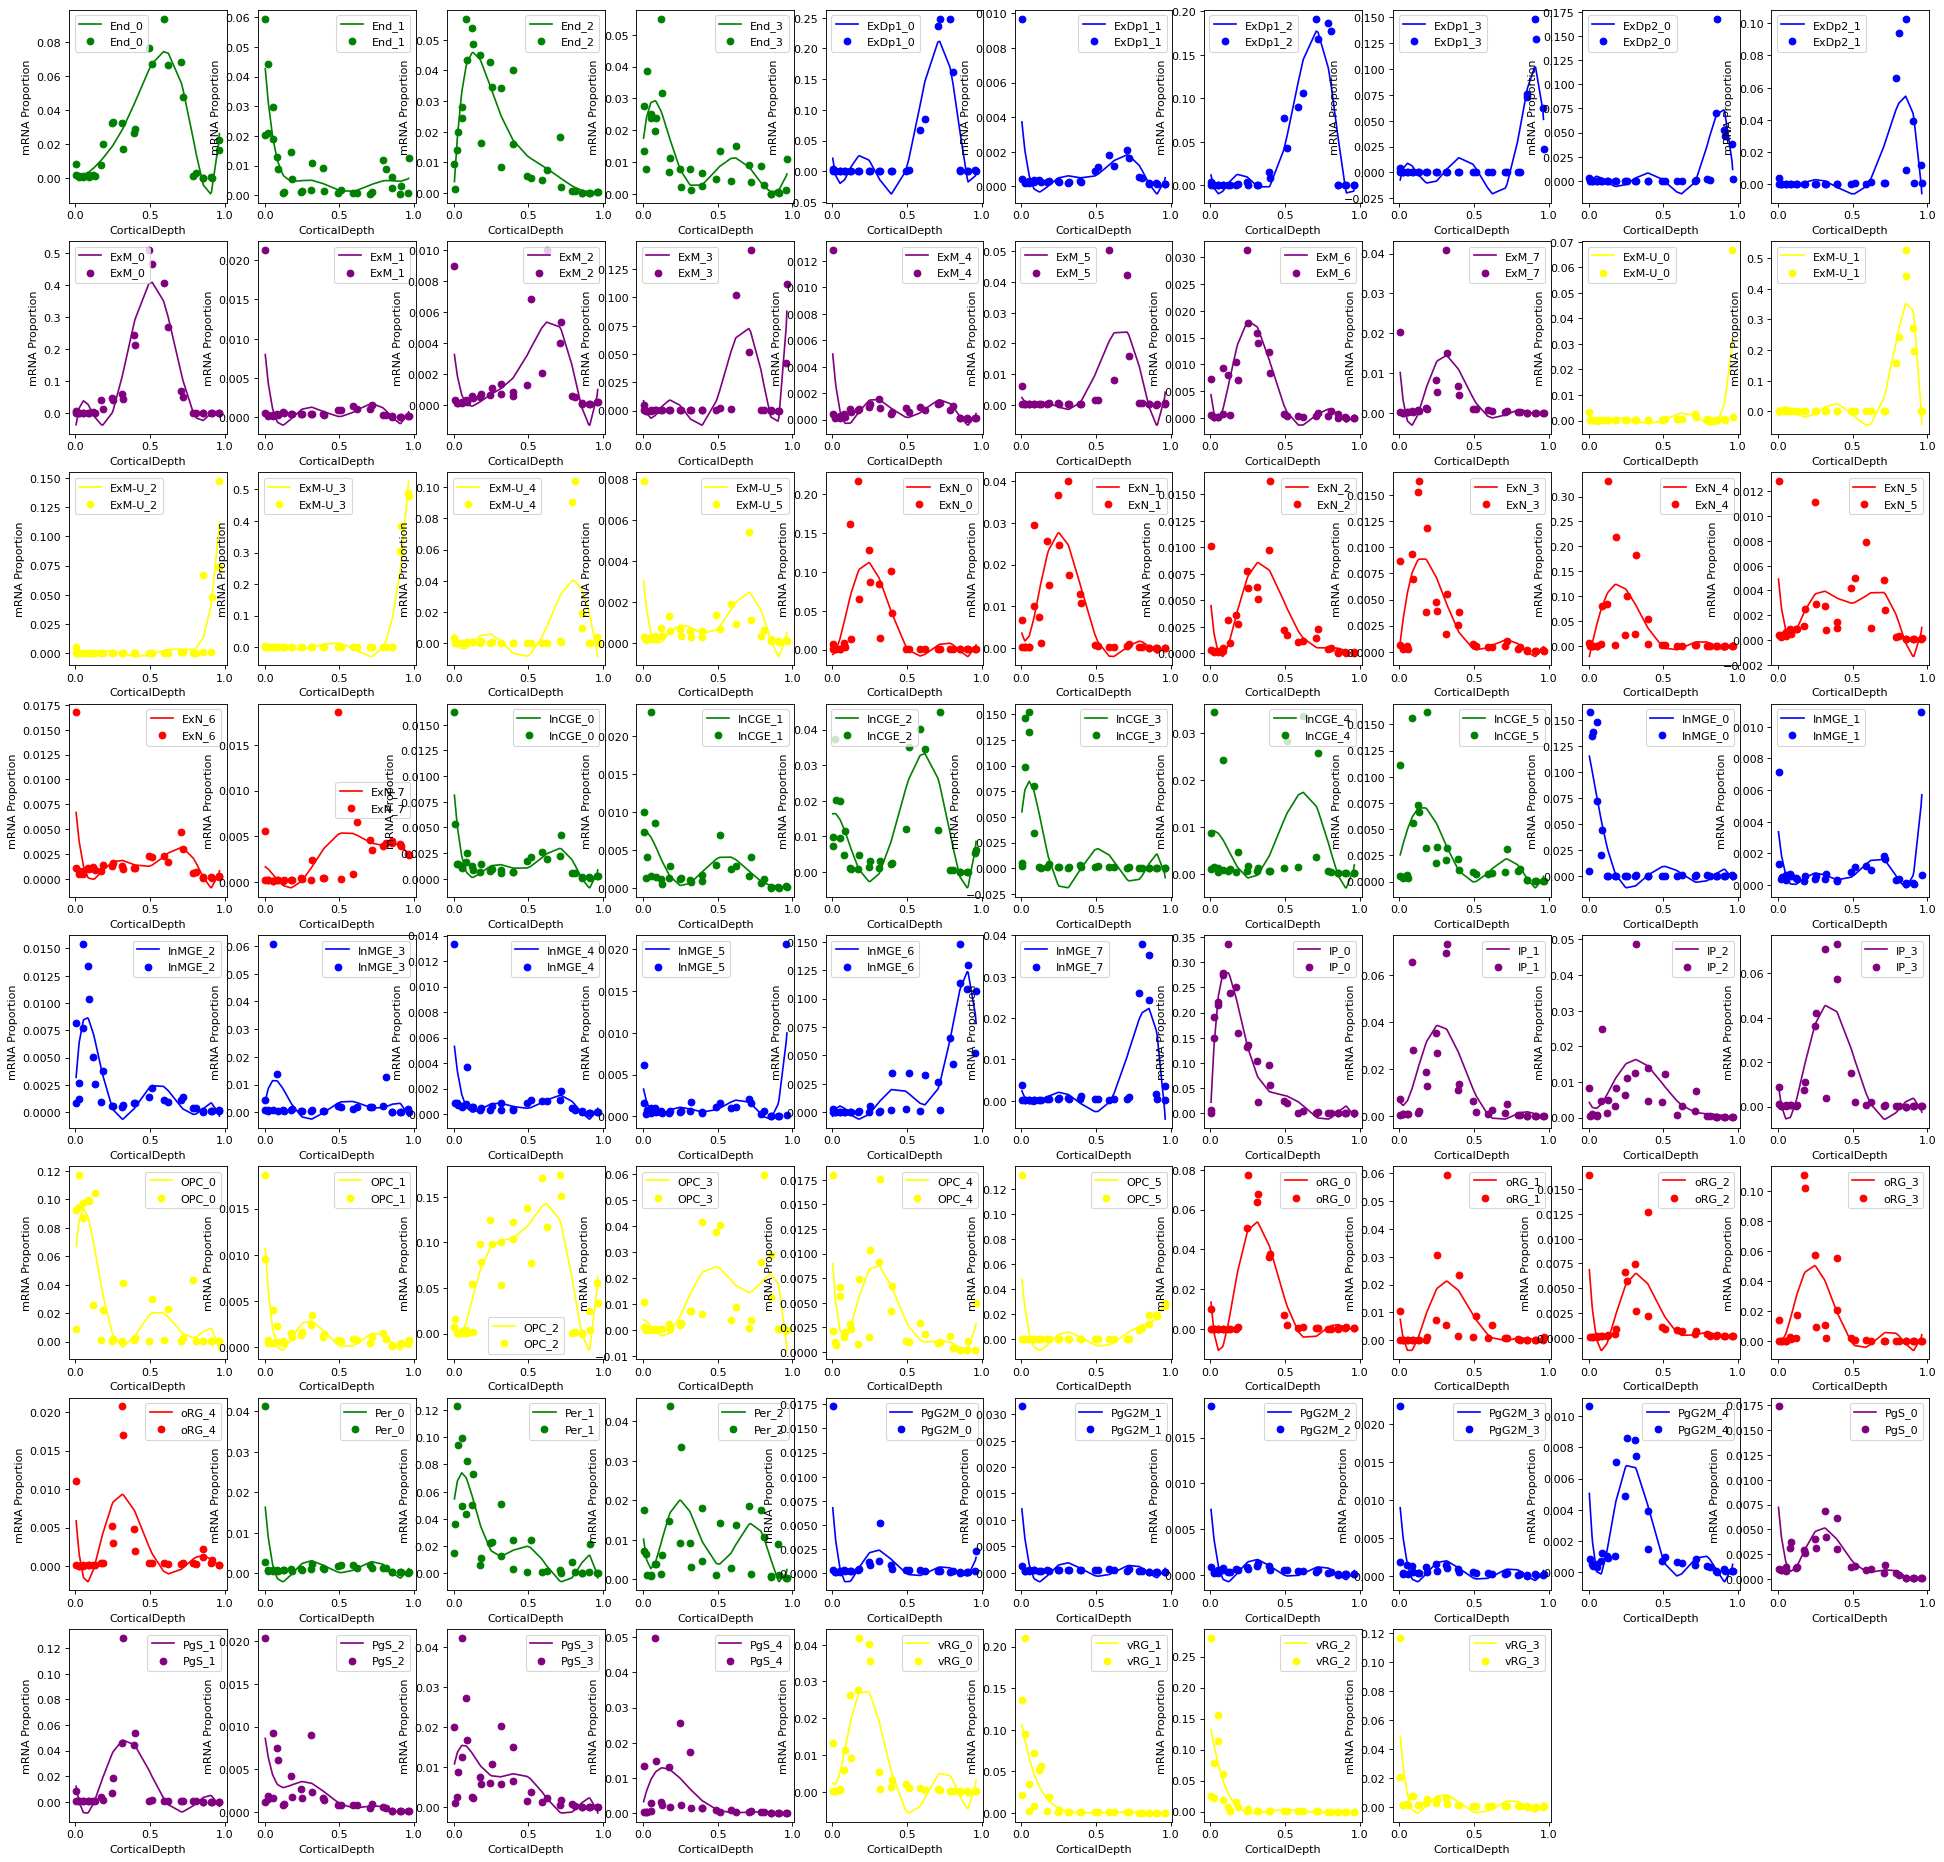

In [8]:
# Plot the results:
colourIndex = np.array((0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 5, 5, 5,
       5, 5, 5, 6, 6, 6,
       6, 6, 6, 6, 6, 7, 7,
       7, 7, 8, 8, 8, 8, 8, 8,
       9, 9, 9, 9, 9, 10, 10, 10,
       11, 11, 11, 11, 11, 12, 12,
       12, 12, 12, 13, 13, 13, 13))

results = mod1.spot_factors_df

results_normed = np.array(results)
results_normed = (results_normed.T/[sum(results_normed[i,]) for i in range(len(results_normed[:,1]))]).T

from matplotlib.pyplot import figure
figure(num=None, figsize=(30, 30), dpi=80, facecolor='w', edgecolor='k')

order = 6

cellColours = np.array(('green', 'blue', 'purple', 'yellow', 'red', 'green', 'blue', 'purple', 'yellow', 'red', 'green', 'blue', 'purple', 'yellow', 'red', 'green', 'blue', 'purple', 'yellow', 'red'))
celltypes = polioudakis.columns
# results_normed = np.array(results)
# results_normed = (results_normed - results_normed.min(0)) / results_normed.ptp(0)
#figsize(20,20)
for i in range(len(celltypes)):
    plt.subplot(8,10, i + 1)
    x = sample_info['x'][subset_rois]
    y = results_normed[:,celltypes == celltypes[i]][:,0]
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, order))(np.unique(x)), label = celltypes[i], c = cellColours[colourIndex[i]])
    plt.scatter(x, y, label = celltypes[i], c = cellColours[colourIndex[i]])
    plt.xlabel('CorticalDepth')
    plt.ylabel('mRNA Proportion')
    plt.legend()
plt.savefig('/nfs/team283/aa16/KR_NAS/CellLocationResults/SubTypeLocations19pcw_PolynomialOrder' + str(order) + '.pdf')
plt.show()

In [9]:
order

6

In [10]:
mod1.nUMI_factors

nUMI_factors

In [11]:
polioudakis_subset

,End_0,End_1,End_2,End_3,ExDp1_0,ExDp1_1,ExDp1_2,ExDp1_3,ExDp2_0,ExDp2_1,...,PgG2M_4,PgS_0,PgS_1,PgS_2,PgS_3,PgS_4,vRG_0,vRG_1,vRG_2,vRG_3
APLP2,0.538462,0.816667,0.76,0.693878,1.044595,0.691814,0.956667,1.684211,1.362637,1.560000,...,1.055556,0.793478,0.749064,0.857143,0.699115,0.804444,0.793478,0.512821,0.665428,0.861446
ARPP21,0.064103,0.016667,0.38,0.020408,2.421622,2.417335,1.401667,3.013158,1.384615,1.720000,...,0.027778,0.043478,0.059925,0.025210,0.026549,0.013333,0.054348,0.021978,0.029740,0.000000
BCL11A,0.038462,0.016667,0.44,0.000000,1.359459,1.277689,1.581667,0.986842,1.175824,1.466667,...,0.444444,0.362319,0.573034,0.315126,0.380531,0.306667,0.275362,0.142857,0.156134,0.156627
BRI3,0.141026,0.233333,0.10,0.081633,0.148649,0.088283,0.086667,0.250000,0.208791,0.240000,...,0.166667,0.101449,0.101124,0.096639,0.132743,0.120000,0.155797,0.153846,0.167286,0.150602
BTG1,0.371795,0.833333,0.72,0.693878,0.089189,0.086677,0.070000,0.026316,0.087912,0.173333,...,0.638889,0.663043,0.464419,0.441176,0.637168,0.600000,0.855072,0.714286,0.810409,0.728916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZEB2,0.025641,0.050000,0.30,0.040816,1.620270,1.638844,1.146667,1.881579,0.186813,0.426667,...,0.194444,0.213768,0.273408,0.260504,0.181416,0.200000,0.224638,0.139194,0.289963,0.283133
ZKSCAN1,0.294872,1.116667,0.40,0.734694,0.614865,0.577849,0.871667,0.894737,0.637363,1.066667,...,0.694444,0.666667,0.977528,0.558824,0.951327,0.715556,0.677536,0.512821,0.650558,0.524096
ZKSCAN5,0.000000,0.066667,0.02,0.040816,0.041892,0.057785,0.056667,0.039474,0.065934,0.053333,...,0.027778,0.025362,0.044944,0.033613,0.017699,0.013333,0.047101,0.029304,0.029740,0.048193
ZMIZ1,0.038462,0.266667,0.10,0.183673,0.254054,0.224719,0.336667,0.236842,0.307692,0.266667,...,0.472222,0.358696,0.378277,0.252101,0.314159,0.173333,0.141304,0.098901,0.092937,0.204819
